# Analysis on E. coli strians

In [2]:
import cobra
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os 
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
## import the dataframe at species level
df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_ecoli=pd.DataFrame(data=df_species.T['k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli']) 
df_ecoli=df_ecoli.drop('PLCL19621_1')
#check E.coli abundance  
print 'number of total samples: ', len(df_ecoli)
print 'number of samples with e.coli greater than 5%: ', sum(i > 1 for i in df_ecoli.values)

## load metadata 
df_meta=pd.read_csv('./data/metadata_updated_filtered_201909.csv',index_col=0)
dic_surgery=dict(zip(df_meta.index,df_meta.surgery_type))
dic_surgeryByHost=dict(zip(df_meta.host_id,df_meta.surgery_type))
dic_host=dict(zip(df_meta.index,df_meta.host_id))
dic_time=dict(zip(df_meta.index,df_meta.time_point_month))

number of total samples:  300
number of samples with e.coli greater than 5%:  [145]


### Compare the E. coli abundance across subgroups 

In [4]:
# add a column to label the surgery subtype

# flatten the dataframe for plotting purpose
surgery_label=[]
for i in df_ecoli.index: 
    if dic_surgery[i]=='none': 
        surgery_label.append('No surgery')
    elif dic_surgery[i]=='colectomy' or dic_surgery[i]=='colectomy with ileorectal' or dic_surgery[i]=='colectomy with ileostomy': 
        surgery_label.append('Colectomy')
    else: 
        surgery_label.append('Ileocolonic')
df_ecoli['surgery']=surgery_label
df_ecoli=df_ecoli.reset_index()

Text(0,0.5,'Relative abundance of E.coli (%)')

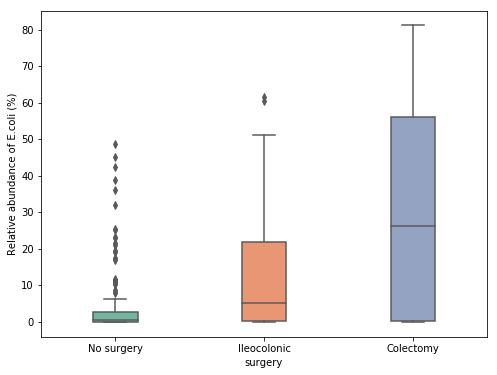

In [5]:
import seaborn as sns 

## add the surgery label to the flattened dataframe 
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(y="k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli", x="surgery",data=df_ecoli,palette=['#66c2a5','#fc8d62','#8da0cb'],
                 width=0.3,order=["No surgery", "Ileocolonic", "Colectomy"])
plt.ylabel('Relative abundance of E.coli (%)')
#fig.savefig('../data/Sandborn_data/figures/E.coli abundance in subgroups.svg')
#fig.savefig('../data/Sandborn_data/figures/E.coli abundance in subgroups.pdf')

### Plot by surgery and disease subtypes

In [6]:
#define subgroups in UC
## missing 5 samples with colectomy+left_sided in all samples 
df_ecoli=df_ecoli.set_index('index')
df_ecoli=df_ecoli['k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli']
df_meta=df_meta.loc[df_ecoli.index]
print (df_meta.shape)
# Define subgroups in UC 
df_uc=df_meta[df_meta.category1=='uc']
print ('UC: ', len(df_uc))
df_uc_nosurgery=df_uc[df_uc.category2=='Control']
print ('UC_no_surgrey: ', len(df_uc_nosurgery))
df_uc_colec_normal=df_uc[df_uc.category3=='Subsequent normal pouch']
print ('UC_colectomy_pouch: ', len(df_uc_colec_normal))
df_uc_colec_cd=df_uc[df_uc.category3=='Subsequent dev of CD']
print ('UC_colectomy_devCD: ', len(df_uc_colec_cd))
df_uc_colec_pouchitis=df_uc[df_uc.category3=='Pouchitis']
print ('UC_colectomy_pouchitis: ', len(df_uc_colec_pouchitis))

# Define subgroups in CD
df_cd=df_meta[df_meta.category1=='cd']
print ('CD: ', len(df_cd))
df_cd_nosurgery=df_cd[df_cd.category2=='Control']
print ('CD_no_surgrey: ', len(df_cd_nosurgery))
df_cd_end=df_cd[df_cd.category2=='End ileostomy']
print ('CD colectomy with end leostomy: ', len(df_cd_end))
df_cd_ileocolonic=df_cd[df_cd.category2=='Ileocolonic resection']
print ('CD_ileocolonic: ', len(df_cd_ileocolonic))
df_cd_col_ileorectal=df_cd[df_cd.category2=='Ileorectal anastomosis']
print ('CD colectomy with ileorectal anastomosis: ', len(df_cd_col_ileorectal))


## extract the alpha diversity 

ecoli_uc_colec_normal=df_ecoli.loc[df_uc_colec_normal.index]
ecoli_uc_colec_pouchitis=df_ecoli.loc[df_uc_colec_pouchitis.index]
ecoli_uc_no=df_ecoli.loc[df_uc_nosurgery.index]
ecoli_uc_CD_pouch=df_ecoli.loc[df_uc_colec_cd.index]

ecoli_cd_ileocolonic=df_ecoli.loc[df_cd_ileocolonic.index]
ecoli_cd_ileostomy=df_ecoli.loc[df_cd_end.index]
ecoli_cd_nosurgery=df_ecoli.loc[df_cd_nosurgery.index]
ecoli_cd_ileorectal=df_ecoli.loc[df_cd_col_ileorectal.index]

(300, 86)
('UC: ', 135)
('UC_no_surgrey: ', 108)
('UC_colectomy_pouch: ', 2)
('UC_colectomy_devCD: ', 15)
('UC_colectomy_pouchitis: ', 10)
('CD: ', 165)
('CD_no_surgrey: ', 97)
('CD colectomy with end leostomy: ', 10)
('CD_ileocolonic: ', 49)
('CD colectomy with ileorectal anastomosis: ', 9)


KruskalResult(statistic=7.467866409727842, pvalue=0.02389865244081126)


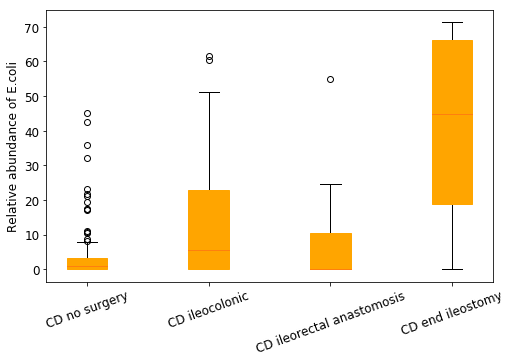

In [8]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[ecoli_cd_nosurgery,ecoli_cd_ileocolonic,ecoli_cd_ileorectal,ecoli_cd_ileostomy]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 5.5, num=4), patch_artist=True,widths=0.5) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='orange')    

ax.set_xticklabels(['CD no surgery','CD ileocolonic','CD ileorectal anastomosis','CD end ileostomy'])
                    
ax.set_ylabel('Relative abundance of E.coli')
ax.set_xlim(0.5,6)
plt.xticks(rotation=20)


from scipy.stats import kruskal
print (kruskal(ecoli_cd_ileocolonic,ecoli_cd_ileorectal,ecoli_cd_ileostomy))
fig.savefig('../../../data/Sandborn_data/figures/figureS3A.svg')

KruskalResult(statistic=2.2366615776081336, pvalue=0.32682487931340215)


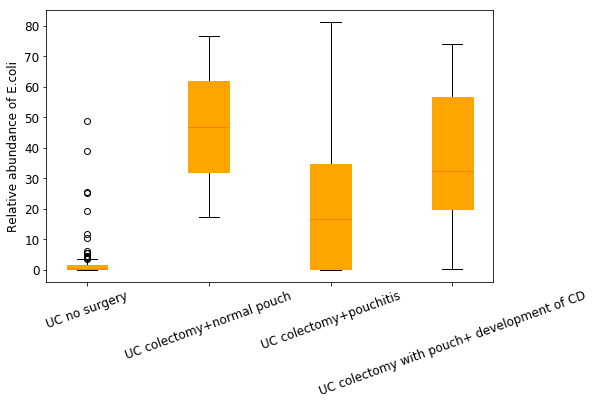

In [9]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[ecoli_uc_no,ecoli_uc_colec_normal,ecoli_uc_colec_pouchitis,ecoli_uc_CD_pouch]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 5.5, num=4), patch_artist=True,widths=0.5) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='orange')   
    
#ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['complication', 'no complication'], loc='upper right')

ax.set_xticklabels(['UC no surgery' ,'UC colectomy+normal pouch','UC colectomy+pouchitis', 'UC colectomy with pouch+ development of CD'])
ax.set_ylabel('Relative abundance of E.coli')
ax.set_xlim(0.5,6)
plt.xticks(rotation=20)

print (kruskal(ecoli_uc_colec_normal,ecoli_uc_colec_pouchitis,ecoli_uc_CD_pouch))
fig.savefig('../../../data/Sandborn_data/figures/figureS3B.svg')

KruskalResult(statistic=6.588909061793021, pvalue=0.010261603570056668)


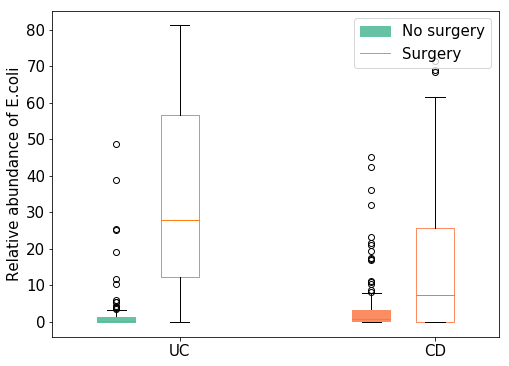

In [15]:
# summarize the data and plot CD and UC separately

ecoli_uc_surgery=pd.concat([ecoli_uc_colec_pouchitis,ecoli_uc_CD_pouch,ecoli_uc_colec_normal])
ecoli_cd_surgery=pd.concat([ecoli_cd_ileorectal,ecoli_cd_ileocolonic,ecoli_cd_ileostomy])
print (kruskal(ecoli_uc_surgery,ecoli_cd_surgery))

data_to_plot=[ecoli_uc_no,ecoli_cd_nosurgery]
data_to_plot2=[ecoli_uc_surgery,ecoli_cd_surgery]

matplotlib.rcParams.update({'font.size': 15})
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=[1,3], patch_artist=True) 
bp2=ax.boxplot(data_to_plot2,positions=[1.5,3.5]) 

# fill with colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
for bplot in (bp1, bp2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_color(color)
    
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['No surgery', 'Surgery'], loc='upper right')

ax.set_xticklabels(['UC','CD'])
ax.set_ylabel('Relative abundance of E.coli')
ax.set_xlim(0.5,4)
fig.savefig('../../../data/Sandborn_data/figures/E.coli abundance in disease subtypes.svg')


(array([1., 2.]), <a list of 2 Text xticklabel objects>)

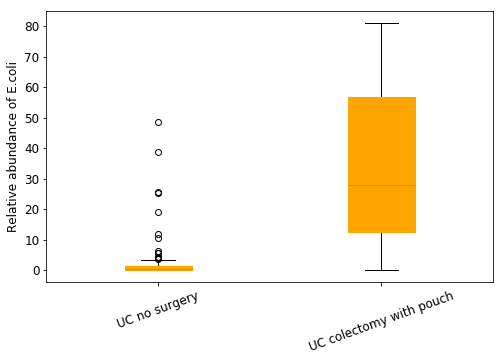

In [10]:
## plot UC colectomy vs control

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[ecoli_uc_no,ecoli_uc_surgery]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 2, num=2), patch_artist=True,widths=0.3) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='orange')   
    
#ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['complication', 'no complication'], loc='upper right')

ax.set_xticklabels(['UC no surgery', 'UC colectomy with pouch'])
ax.set_ylabel('Relative abundance of E.coli')
ax.set_xlim(0.5,2.5)
plt.xticks(rotation=20)


### Statistical test: only include one sample per patient 

In [11]:
## create dictionary for host info 
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
                   
##empty list to store host info 
cd_ileorectal2=[]
cd_ileocolonic2=[]
cd_ileostomy2=[]
host_ilerectal=[]
host_ileocolonic=[]
host_ileostomy=[]

##only 1 sample per patient 

for s in ecoli_cd_ileorectal.index: 
    if not dic_sample_host[s] in host_ilerectal: 
        host_ilerectal.append(dic_sample_host[s])
        cd_ileorectal2.append(s)

for s in ecoli_cd_ileocolonic.index: 
    if not dic_sample_host[s] in host_ileocolonic: 
        host_ileocolonic.append(dic_sample_host[s])
        cd_ileocolonic2.append(s)

for s in ecoli_cd_ileostomy.index: 
    if not dic_sample_host[s] in host_ileostomy: 
        host_ileostomy.append(dic_sample_host[s])
        cd_ileostomy2.append(s)
ecoli_cd_ileorectal2=ecoli_cd_ileorectal.loc[cd_ileorectal2]
ecoli_cd_ileocolonic2=ecoli_cd_ileocolonic.loc[cd_ileocolonic2]
ecoli_cd_ileostomy2=ecoli_cd_ileostomy.loc[cd_ileostomy2]
print (kruskal(ecoli_cd_ileorectal2,ecoli_cd_ileocolonic2,ecoli_cd_ileostomy2))


KruskalResult(statistic=2.28712174524982, pvalue=0.3186822122348627)


## Investigate dynamics of dominant strain  using SNP profiles generated by MIDAS

SNP profiles for E.coli were generated for 178 samples with using MIDAS with the following command with default settings: 

run_midas.py snps output_folder --species_id Escherichia_coli_58110 -t 24 -1 sample.R1.fastq.gz -2 sample.R2.fastq.gz 



In [12]:
#load dataframe SNP 

df_snp=pd.read_csv('./data/snps_freq.txt',sep='\t',index_col=0)
print df_snp.shape
df_snp=df_snp.drop('PLCL22251',1)

df_snp.head()

(24641, 179)


,PLCL18250,PLCL22166,PLCL23147,PLCL20066,PLCL20088,PLCL24015,PLCL18755,PLCL17842,PLCL23175,PLCL20124,...,PLCL19273,PLCL20974,PLCL21475,PLCL25745_1,PLCL21491,PLCL17719,PLCL18909,PLCL18260,PLCL22156,PLCL19578
site_id,,,,,,,,,,,,,,,,,,,,,
352,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00000,0.00000,0.000,0.0,0.0,0.0,0.0,0.001650,0.00000,0.0000
516,0.0000,0.0,0.000,0.0,0.0,1.0,0.0,0.870,1.0,0.000,...,1.00000,0.00000,0.549,0.0,0.0,1.0,1.0,0.000329,0.00889,0.0556
1082,0.0000,0.0,0.545,0.0,0.0,0.0,0.0,0.615,1.0,0.333,...,1.00000,0.00000,0.924,0.0,0.0,1.0,1.0,0.000000,0.00000,0.1110
1102,0.0000,0.0,0.000,0.0,0.0,1.0,0.0,0.636,0.0,0.000,...,0.99900,0.00000,0.000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0500
1103,0.0244,0.0,0.333,0.0,0.0,1.0,0.0,0.000,1.0,0.333,...,0.00112,0.00501,0.924,0.0,0.0,1.0,1.0,0.008720,0.00000,0.0909


In [13]:
## filter for host that has more than 1 E.coli samples for plot 
dic_count={}
for s in df_snp.columns: 
    host=dic_host[s]
    if not host in dic_count: 
        dic_count[host]=1
    else: 
        dic_count[host]=dic_count[host]+1

host_longi=[k for k in dic_count.keys() if dic_count[k]>1]
sample_longi=[s for s in df_snp.columns if dic_host[s] in host_longi]
df_pan_longi=df_snp[sample_longi]
df_pan_longi.shape

#remove genes that are not present in any sandborn strains 
gene_present=[g for g in df_pan_longi.index if sum(df_pan_longi.loc[g]>0)]
df_pan_longi=df_pan_longi.loc[gene_present]

KeyError: 'PLCL19621_1'

In [ ]:
#create a dataframe to store the host/time for each samples 
hostlist=[]
timelist=[]
for s in sample_longi: 
    hostlist.append(dic_host[s])
    timelist.append(dic_time[s])
df_info=pd.DataFrame(index=sample_longi)
df_info['host']=hostlist
df_info['time']=timelist
df_info=df_info.sort_values(by=['host','time'])
df_info

In [8]:
#calculate the distance for each neighboring dominant strain based on snp profiles
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

dic_distance={}
for h in host_longi: 
    df_temp=df_info[df_info.host==h]
    for i in range(len(df_temp)-1): 
        s1=df_temp.iloc[i].name
        s2=df_temp.iloc[i+1].name
        dist=pdist(df_pan_longi[[s1,s2]],metric='mahalanobis')
        if not h in dic_distance.keys(): 
            dic_distance[h]=[dist[0]]
        else: 
            dic_distance[h].append(dist[0])
# select a value to fill in the non-existing samples to allow plotting later     
    while len(dic_distance[h])<3: 
        dic_distance[h].append(4)

In [9]:
df_disctance=pd.DataFrame.from_dict(dic_distance).T
df_disctance=df_disctance.replace(to_replace=-1,value=4)

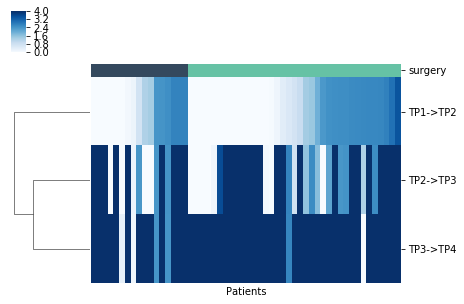

In [22]:
#create label for surgery for hosts 
patient_col=[]
for i in df_disctance.index: 
    if dic_surgeryByHost[i]=='none': 
        patient_col.append('#66c2a5')
    else: 
        patient_col.append('#34495e')

df_disctance['surgery']=patient_col

#add surgery status to the plot 
df_disctance=df_disctance.sort_values(by=['surgery',0,1,2])
g=sns.clustermap(df_disctance[[0,1,2]].T,cmap='Blues',figsize=(7,5),col_colors=df_disctance['surgery'],col_cluster=False,mask=0)
ax = g.ax_heatmap
ax.set_yticklabels(['TP1->TP2','TP2->TP3','TP3->TP4'],rotation=0)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel('Patients')
#g.savefig('../data/Sandborn_data/figures/Dominant Ecoli strain Change similarity.svg')
#g.savefig('../data/Sandborn_data/figures/Dominant Ecoli strain Change similarity.pdf')

## Analyze Panphlan results
Gene presence/absence matrix of E.coli is generated for 147 samples with E.coli abundance greater than 1% using Panphlan. Panphlan was run with default settings and the database used was "ecoli16" downloaded provided on the Panphlan website

In [14]:
##load panphlan results 

df_panphlan=pd.read_csv('./data/gene_presence_ecoli16.csv',index_col=0,sep='\t')

#only keep the samples from sandborn data 
sandborn_sample=[i for i in df_panphlan.columns if 'PLCL' in i]
df_panphlan=df_panphlan[sandborn_sample]
df_panphlan=df_panphlan.drop('PLCL22251',1)
print df_panphlan.shape


(31734, 147)


### Analysis on metabolic functions
Draft metabolic genome scale models were created based on genome content identified by panphlan for each sample.
Then the pan reactome matrix is created that specifies the presence/absence of each metabolic reaction in the sample-specific draft models. Here we analyze the pre-computed pan-reactome matrix

In [15]:
#only look at sandborn samples 
df_rxn=pd.read_csv('./data/pan_reactome_matrix.csv',index_col=0)
df_rxn_samples=df_rxn[sandborn_sample]
df_rxn_samples=df_rxn_samples.drop('PLCL22251',1)
df_rxn_samples.shape


(3077, 147)

### Analysis on AIEC associated virulence factors
We mapped the Panphlan derived assemblies against a reference databse with AIEC associated VFs using BLAST. Here we look at the output results that specified the sequence similarity of each VF in all assemblies

In [16]:
## load mapping results from VF genes 
df_AIEC_map=pd.read_csv('./data/AIEC_VF_comparative.csv',index_col=0)
df_AIEC_map=df_AIEC_map.fillna(value=0)
df_AIEC_map.shape
df_AIEC_sample=df_AIEC_map[df_rxn_samples.columns]
df_AIEC_sample.shape

#concat AIEC+ mtabolism

df_VF_metab=pd.concat([df_AIEC_sample,df_rxn_samples])
print df_VF_metab.shape

(3102, 147)


In [17]:
import mca
#create MCA instance 
X=df_VF_metab.T
mca_ben = mca.MCA(X,TOL=1e-9)
mca_ind = mca.MCA(X, benzecri=False,TOL=1e-9)
fs=np.asarray(mca_ben.fs_r(N=4))
mca_ben.expl_var(greenacre=True, N=4)

array([0.73497173, 0.11436956, 0.04364698, 0.03042905])

### MCA plot on VF and metabolic reaction matrix

In [18]:
#label the plot 

color_surgery=[]
for i in df_VF_metab.columns: 
    if dic_surgery[i]=='none': 
        color_surgery.append('#66c2a5')
    else: 
        color_surgery.append('#34495e')


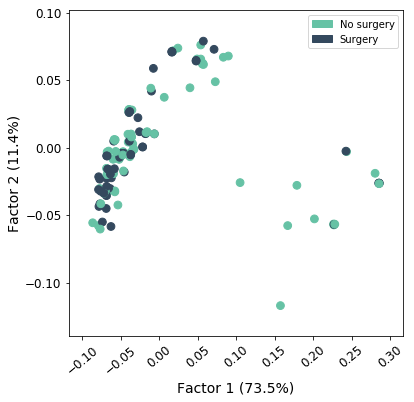

In [19]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
n=list(df_VF_metab.columns)
plot=ax.scatter(fs[:,0],fs[:,1],s=60, c=color_surgery)
plt.xlabel('Factor 1 (73.5%)',fontsize=14)
plt.ylabel('Factor 2 (11.4%)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=40)
plt.grid(False)
blue = mpatches.Patch(color='#66c2a5', label='No surgery')
brown = mpatches.Patch(color='#34495e', label='Surgery')
plt.legend(handles=[blue,brown])
#fig.savefig('../data/Sandborn_data/figures/Metabolis and VF dominant ecoli strians.svg')
#fig.savefig('../data/Sandborn_data/figures/Metabolis and VF dominant ecoli strians.pdf')